In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import warnings
warnings.filterwarnings('ignore')
#pd.set_option("display.max_columns",50)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler,MaxAbsScaler
from sklearn.model_selection import cross_val_score,GridSearchCV,StratifiedKFold,RepeatedStratifiedKFold,RandomizedSearchCV
from sklearn.metrics import accuracy_score,auc,recall_score,precision_score,precision_recall_curve,confusion_matrix,\
plot_confusion_matrix,plot_precision_recall_curve,plot_roc_curve,classification_report,roc_auc_score,f1_score
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer,MissingIndicator,SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [3]:
import re
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(style="darkgrid") #white, dark, whitegrid, darkgrid, ticks


In [4]:
path = r"C:/Users/Krishna/Documents/kaggle/AV_HR_Hackathon"

In [5]:
train = pd.read_csv(f'{path}/input/train_jqd04QH.csv',dtype = {'enrollee_id':str})
test = pd.read_csv(f'{path}/input/test_KaymcHn.csv',dtype = {'enrollee_id':str})

f'train dimensions are : {train.shape}'
f'test dimensions are : {test.shape}'

train.head(2)
test.head(2)


'train dimensions are : (18359, 14)'

'test dimensions are : (15021, 13)'

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,23798,city_149,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,3,100-500,Pvt Ltd,1,106,0
1,29166,city_83,0.923,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,<10,Funded Startup,1,69,0


,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,16548,city_33,0.448,NaN,No relevent experience,Full time course,Graduate,STEM,<1,1000-4999,Public Sector,NaN,15
1,12036,city_28,0.939,Male,No relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,1,94


In [6]:
def data_info(df = train):
    df_info = pd.DataFrame(df.isna().sum(),columns = ['Null_count'])
    df_info['Non_Null_count'] = df_info.index.map(df.notna().sum())
    df_info['N_unique'] = df_info.index.map(df.nunique())
    df_info['D_types'] = df_info.index.map(df.dtypes)
    df_info['Blank_count'] = df_info.index.map((df=='').sum())
    return df_info

In [7]:
data_info(train)

,Null_count,Non_Null_count,N_unique,D_types,Blank_count
enrollee_id,0,18359,18359,object,0
city,0,18359,123,object,0
city_development_index,0,18359,93,float64,0
gender,4098,14261,3,object,0
relevent_experience,0,18359,2,object,0
enrolled_university,342,18017,3,object,0
education_level,457,17902,5,object,0
major_discipline,2838,15521,6,object,0
experience,59,18300,22,object,0
company_size,4779,13580,8,object,0


### checking event rate 

In [8]:
from collections import Counter
Counter(train.target)
train.target.value_counts(normalize=True) # works for numeric columns too with arguement `bins`
#train.city_development_index.value_counts(bins =6)

Counter({0: 15934, 1: 2425})

0    0.867912
1    0.132088
Name: target, dtype: float64

### treating null values

In [9]:
var = 'gender'
#f'count of NULLs in {var} : {train[[var]].isna().sum()[0]}'
train[var].value_counts(dropna = False,normalize = True)
pd.crosstab(index = train[var].fillna('Nan'), columns = train.target,margins = True,normalize='index',)

Male      0.701781
NaN       0.223215
Female    0.064709
Other     0.010295
Name: gender, dtype: float64

target,0,1
gender,,
Female,0.849327,0.150673
Male,0.877523,0.122477
Nan,0.844070,0.155930
Other,0.846561,0.153439
All,0.867912,0.132088


### creating NA indicator for all the columns containing NAs

In [10]:
mindicator = MissingIndicator(missing_values=np.nan,error_on_new=False)
z = mindicator.fit_transform(train.drop('target',axis = 1))

In [11]:
cols_na_ind = [x+'_na_ind' for x in train.columns[mindicator.features_]]
train = pd.concat([train,pd.DataFrame(1*z,columns = cols_na_ind)],axis = 1)
train.head(1)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,...,training_hours,target,gender_na_ind,enrolled_university_na_ind,education_level_na_ind,major_discipline_na_ind,experience_na_ind,company_size_na_ind,company_type_na_ind,last_new_job_na_ind
0,23798,city_149,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,3,100-500,...,106,0,0,0,0,0,0,0,0,0


In [12]:
z = mindicator.transform(test)
cols_na_ind = [x+'_na_ind' for x in test.columns[mindicator.features_]]
test = pd.concat([test,pd.DataFrame(1*z,columns = cols_na_ind)],axis = 1)
test.head(1)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,...,last_new_job,training_hours,gender_na_ind,enrolled_university_na_ind,education_level_na_ind,major_discipline_na_ind,experience_na_ind,company_size_na_ind,company_type_na_ind,last_new_job_na_ind
0,16548,city_33,0.448,NaN,No relevent experience,Full time course,Graduate,STEM,<1,1000-4999,...,NaN,15,1,0,0,0,0,0,0,1


In [13]:
var = 'gender'
train[var].value_counts(dropna = False,normalize=True)
pd.crosstab(index = train[var].fillna('Nan'), columns = train.target,margins = True,normalize='index',)

Male      0.701781
NaN       0.223215
Female    0.064709
Other     0.010295
Name: gender, dtype: float64

target,0,1
gender,,
Female,0.849327,0.150673
Male,0.877523,0.122477
Nan,0.844070,0.155930
Other,0.846561,0.153439
All,0.867912,0.132088


In [14]:
var = 'enrolled_university'
train[var].value_counts(dropna = False,normalize=True)
pd.crosstab(index = train[var].fillna('Nan'), columns = train.target,margins = True,normalize='index',)

no_enrollment       0.743995
Full time course    0.173593
Part time course    0.063783
NaN                 0.018628
Name: enrolled_university, dtype: float64

target,0,1
enrolled_university,,
Full time course,0.809539,0.190461
Nan,0.836257,0.163743
Part time course,0.851409,0.148591
no_enrollment,0.883740,0.116260
All,0.867912,0.132088


In [15]:
var = 'education_level'
train[var].value_counts(dropna=False,normalize=True)
pd.crosstab(index = train[var].fillna('Nan'), columns = train.target,margins = True,normalize=True,dropna=False)

Graduate          0.586579
Masters           0.235252
High School       0.110681
Phd               0.025001
NaN               0.024892
Primary School    0.017594
Name: education_level, dtype: float64

target,0,1,All
education_level,,,
Graduate,0.503132,0.083447,0.586579
High School,0.097554,0.013127,0.110681
Masters,0.207310,0.027943,0.235252
Nan,0.021570,0.003323,0.024892
Phd,0.022114,0.002887,0.025001
Primary School,0.016232,0.001362,0.017594
All,0.867912,0.132088,1.000000


In [16]:
var = 'major_discipline'
train[var].value_counts(dropna=False,normalize=True)
pd.crosstab(index = train[var].fillna('Nan'), columns = train.target,margins = True,dropna = False,normalize='index')

STEM               0.748298
NaN                0.154584
Humanities         0.037475
Other              0.018683
Business Degree    0.016722
Arts               0.013018
No Major           0.011221
Name: major_discipline, dtype: float64

target,0,1
major_discipline,,
Arts,0.895397,0.104603
Business Degree,0.872964,0.127036
Humanities,0.864826,0.135174
Nan,0.882311,0.117689
No Major,0.902913,0.097087
Other,0.892128,0.107872
STEM,0.863372,0.136628
All,0.867912,0.132088


In [17]:
var = 'experience'
#train[var].value_counts(dropna=False,normalize=True)
pd.crosstab(index = train[var].fillna('Nan'), columns = train.target,margins = True,dropna = False,normalize='index',)

target,0,1
experience,,
1,0.761062,0.238938
10,0.875905,0.124095
11,0.875562,0.124438
12,0.895372,0.104628
13,0.883495,0.116505
14,0.875415,0.124585
15,0.889209,0.110791
16,0.896175,0.103825
17,0.902017,0.097983


In [52]:
na_cols = train.isna().sum()[train.isna().sum()>0].index
fillna_vals = dict(zip(na_cols,len(na_cols)*['missing']))
fillna_vals

{'gender': 'missing',
 'enrolled_university': 'missing',
 'education_level': 'missing',
 'major_discipline': 'missing',
 'experience': 'missing',
 'company_size': 'missing',
 'company_type': 'missing',
 'last_new_job': 'missing'}

In [53]:
train.fillna(fillna_vals,inplace = True)

test.fillna(fillna_vals,inplace = True)

In [54]:
data_info(train.loc[:,~train.columns.str.contains('_na_ind')])

,Null_count,Non_Null_count,N_unique,D_types,Blank_count
enrollee_id,0,18359,18359,object,0
city,0,18359,123,object,0
city_development_index,0,18359,93,float64,0
gender,0,18359,4,object,0
relevent_experience,0,18359,2,object,0
enrolled_university,0,18359,4,object,0
education_level,0,18359,6,object,0
major_discipline,0,18359,7,object,0
experience,0,18359,23,object,0
company_size,0,18359,9,object,0


In [55]:
train.to_csv(f'{path}/train_null_rem_1.csv',index= False)
test.to_csv(f'{path}/test_null_rem_1.csv',index= False)

<center><b> ***THE END** </center></b>

In [56]:
train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,...,training_hours,target,gender_na_ind,enrolled_university_na_ind,education_level_na_ind,major_discipline_na_ind,experience_na_ind,company_size_na_ind,company_type_na_ind,last_new_job_na_ind
0,23798,city_149,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,3,100-500,...,106,0,0,0,0,0,0,0,0,0
1,29166,city_83,0.923,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,<10,...,69,0,0,0,0,0,0,0,0,0
2,46,city_16,0.910,missing,Has relevent experience,no_enrollment,Graduate,STEM,6,50-99,...,4,0,1,0,0,0,0,0,0,0
3,18527,city_64,0.666,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,50-99,...,26,0,0,0,0,0,0,0,0,0
4,21751,city_100,0.887,missing,No relevent experience,no_enrollment,Masters,STEM,8,missing,...,88,1,1,0,0,0,0,1,1,0


In [210]:
train['city_event_rate'] = train.city.map(train.groupby('city').target.mean())
test['city_event_rate'] = test.city.map(train.groupby('city').target.mean())

In [211]:
var = 'major_discipline'
temp = train[var].value_counts(normalize=True)
temp = pd.Series(temp[temp> 0.03].index)
#temp
train[var] = np.where(train[var].isin(temp), train[var],'low_pop')
train[var].value_counts(normalize=True)
test[var] = np.where(test[var].isin(temp), test[var],'low_pop')

STEM          0.748298
missing       0.154584
low_pop       0.059644
Humanities    0.037475
Name: major_discipline, dtype: float64

In [212]:
var = 'company_size'
temp = train[var].value_counts(normalize=True)
temp = pd.Series(temp[temp> 0.05].index)
#temp
train[var] = np.where(train[var].isin(temp), train[var],'low_pop')
train[var].value_counts(normalize=True)
test[var] = np.where(test[var].isin(temp), test[var],'low_pop')


missing      0.260308
50-99        0.169944
100-500      0.146958
10000+       0.111335
low_pop      0.081323
10/49        0.079852
1000-4999    0.076202
<10          0.074078
Name: company_size, dtype: float64

In [213]:
var = 'company_type'
temp = train[var].value_counts(normalize=True)
temp = pd.Series(temp[temp> 0.05].index)
#temp
train[var] = np.where(train[var].isin(temp), train[var],'low_pop')
train[var].value_counts(normalize=True)
test[var] = np.where(test[var].isin(temp), test[var],'low_pop')

Pvt Ltd           0.547470
missing           0.274470
low_pop           0.067269
Funded Startup    0.056539
Public Sector     0.054251
Name: company_type, dtype: float64

In [214]:
var = 'last_new_job'
temp = train[var].value_counts(normalize=True)
temp = pd.Series(temp[temp> 0.05].index)
#temp
train[var] = np.where(train[var].isin(temp), train[var],'low_pop')
train[var].value_counts(normalize=True)
test[var] = np.where(test[var].isin(temp), test[var],'low_pop')


1        0.432159
>4       0.181873
2        0.154420
never    0.119070
4        0.056539
3        0.055940
Name: last_new_job, dtype: float64

In [215]:
data_info(train)

,Null_count,Non_Null_count,N_unique,D_types,Blank_count
enrollee_id,0,18359,18359,object,0
city,0,18359,123,object,0
city_development_index,0,18359,93,float64,0
gender,0,18359,4,object,0
relevent_experience,0,18359,2,object,0
enrolled_university,0,18359,3,object,0
education_level,0,18359,6,object,0
major_discipline,0,18359,4,object,0
experience,0,18359,22,object,0
company_size,0,18359,8,object,0


In [107]:
#,normalize='index',)
#                 colnames= {0 :'Non_Event', 1:'Event'})

In [166]:
var = 'experience'
df = pd.crosstab(index = train[var], columns = train.target,margins = True).reset_index()

df.experience = pd.to_numeric(df.experience.replace({'<1': '0', '>20' : '21', 'All' : '100'}))
df = df.rename({0 :'Non_Event', 1:'Event'}, axis = 1)
df['Non_Event_%'] =  df.Non_Event/df.All
df['Event_%'] =  df.Event/df.All
df['woe'] = np.log(df['Event_%']/df['Non_Event_%'])
df['IV'] = (df['Event_%'] - df['Non_Event_%'])*df['woe']
df.sort_values('experience',inplace = True)#.reset_index(drop = True)
df.head(1)

target,experience,Non_Event,Event,All,Non_Event_%,Event_%,woe,IV
20,0,315,101,416,0.757212,0.242788,-1.137452,0.585132


In [ ]:
>= 7 [8-15] <15


In [216]:
train['experience_band'] = pd.to_numeric(train.experience.replace({'<1': '0', '>20' : '21', 'All' : '100'}))
train['experience_band'] = np.where(train.experience_band <= 7 , 'low_exp',np.where(train.experience_band >= 16, 'high_exp', 'med_exp'))

test['experience_band'] = pd.to_numeric(test.experience.replace({'<1': '0', '>20' : '21', 'All' : '100'}))
test['experience_band'] = np.where(test.experience_band <= 7 , 'low_exp',np.where(test.experience_band >= 16, 'high_exp', 'med_exp'))

In [468]:
train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target,city_event_rate,experience_band
0,23798,city_149,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,3,100-500,Pvt Ltd,1,106,0,0.123810,low_exp
1,29166,city_83,0.923,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,<10,Funded Startup,1,69,0,0.098592,med_exp
2,46,city_16,0.910,missing,Has relevent experience,no_enrollment,Graduate,STEM,6,50-99,Public Sector,2,4,0,0.093108,low_exp
3,18527,city_64,0.666,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,50-99,Pvt Ltd,1,26,0,0.100840,med_exp
4,21751,city_100,0.887,missing,No relevent experience,no_enrollment,Masters,STEM,8,missing,missing,2,88,1,0.162362,med_exp


In [467]:
train.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target', 'city_event_rate',
       'experience_band'],
      dtype='object')

In [471]:
train.education_level.value_counts(normalize=True)

Graduate          0.586579
Masters           0.235252
High School       0.110681
Phd               0.025001
missing           0.024892
Primary School    0.017594
Name: education_level, dtype: float64

In [ ]:
edu_lev_dict = {}

In [ ]:
education_level,experience,company_size,last_new_job

In [ ]:
gender,relevent_experience,enrolled_university,major_discipline,company_type


In [294]:
# 5 - DIct Vectorizer on train and transforming it on test
def dict_vec(train_set,cols,is_test, test_set):
    """
    returns dict vectorizer on train set or train & test set for chosen columns
    train_set: Dataset on which DV is to be fit
    cols: List of columns of train_set which are to be considered for DV
    is_test: Boolean, If DV is to be transformed on test too
    test_set: Test set on which DV is to be transformed
    """
    from sklearn.feature_extraction import DictVectorizer
    import pandas as pd
    dvec = DictVectorizer(sparse=False)
    if not is_test:
        train_dvec = dvec.fit_transform(train_set[cols].transpose().to_dict().values())
        train_dvec = pd.DataFrame(train_dvec, index = train_set.index, columns = dvec.get_feature_names())
        train_df = pd.concat([train_set.drop(cols, axis = 1),train_dvec], axis = 1)
        return train_df,pd.DataFrame(),dvec
    else:
        train_dvec = dvec.fit_transform(train_set[cols].transpose().to_dict().values())
        train_dvec = pd.DataFrame(train_dvec, index = train_set.index, columns = dvec.get_feature_names())
        train_df = pd.concat([train_set.drop(cols, axis = 1),train_dvec], axis = 1)
        test_dvec = dvec.transform(test_set[cols].transpose().to_dict().values())
        test_dvec = pd.DataFrame(test_dvec, index = test_set.index, columns = dvec.get_feature_names())
        test_df = pd.concat([test_set.drop(cols, axis = 1),test_dvec], axis = 1)
        return train_df, test_df,dvec

In [295]:
obj_cols = train.drop(['enrollee_id','city', 'experience'],axis = 1).select_dtypes('object').columns
#obj_cols = [x for x in train.columns if x != 'enrollee_id' or x != 'city']
obj_cols

Index(['gender', 'relevent_experience', 'enrolled_university',
       'education_level', 'major_discipline', 'company_size', 'company_type',
       'last_new_job', 'experience_band'],
      dtype='object')

In [296]:
df_train,df_test,dv = dict_vec(train, obj_cols,is_test = True,test_set =test)

In [373]:
df_train.shape; df_test.shape
df_train.columns

(18359, 48)

(15021, 47)

Index(['enrollee_id', 'city', 'city_development_index', 'experience',
       'training_hours', 'target', 'city_event_rate', 'company_size=10/49',
       'company_size=100-500', 'company_size=1000-4999', 'company_size=10000+',
       'company_size=50-99', 'company_size=smlr10', 'company_size=low_pop',
       'company_size=missing', 'company_type=Funded Startup',
       'company_type=Public Sector', 'company_type=Pvt Ltd',
       'company_type=low_pop', 'company_type=missing',
       'education_level=Graduate', 'education_level=High School',
       'education_level=Masters', 'education_level=Phd',
       'education_level=Primary School', 'education_level=missing',
       'enrolled_university=Full time course',
       'enrolled_university=Part time course',
       'enrolled_university=no_enrollment', 'experience_band=high_exp',
       'experience_band=low_exp', 'experience_band=med_exp', 'gender=Female',
       'gender=Male', 'gender=Other', 'gender=missing', 'last_new_job=1',
       'las

In [299]:
fin_cols = pd.Series(df_train.columns)
#fin_cols
df_train.columns = fin_cols.apply(lambda x : re.sub('>', 'grtr',x)).apply(lambda x : re.sub('<', 'smlr',x))

In [321]:
fin_cols_test = pd.Series(df_test.columns)
#fin_cols
df_test.columns = fin_cols_test.apply(lambda x : re.sub('>', 'grtr',x)).apply(lambda x : re.sub('<', 'smlr',x))

In [335]:
df_train.to_csv(f'{path}/train_for_model.csv',index= False)
df_test.to_csv(f'{path}/test_for_model.csv',index= False)

# Modelling

In [435]:
X_train, X_test, y_train, y_test = train_test_split(df_train[features],\
                df_train.target,test_size = 0.15, random_state = 69, stratify = df_train.target)

In [436]:
X_train.shape
X_test.shape

(15605, 44)

(2754, 44)

In [437]:
y_train.value_counts()
11950/1819

0    13544
1     2061
Name: target, dtype: int64

6.569543705332601

In [438]:
np.arange(0.5,8,1)

array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5])

In [439]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': np.arange(0.5,1,0.1),
        'colsample_bytree': np.arange(0.5,1,0.1),
        'max_depth': np.arange(3,11,1),
        'n_estimators': np.arange(100,501,50),
        'max_delta_step' : np.arange(1,8,1),
        'bootstrap' : [True, False]
        }

In [440]:
XGBClassifier()

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='binary:logistic', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=False, verbosity=None)

In [441]:
xgb = XGBClassifier(learning_rate=0.02, objective='binary:logistic',
                    silent=True, n_jobs = -1,random_state = 53)

In [443]:
folds = 3
param_comb = 20

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

In [448]:
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, \
          scoring='f1_macro', n_jobs=-1, cv=skf, verbose=3, random_state=1001 )

In [449]:
%%time
random_search.fit(X_train, y_train);

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.9min finished


Wall time: 4min 3s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=1001, shuffle=True),
                   error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=0.02,
                                           max_delta_step=None, max_depth=None,
                                           min_...
                                        'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'max_delta_step': array([1, 2, 3, 4, 5, 6, 7

In [466]:
estimator= random_search
pred_bin_tr = estimator.predict(X_train)
pred_bin_te = estimator.predict(X_test)
f'train_roca : {roc_auc_score(y_train,estimator.predict_proba(X_train)[:,1])} ; test_roca : {roc_auc_score(y_test,estimator.predict_proba(X_test)[:,1])}'
f'train_f1_s : {f1_score(y_train,pred_bin_tr)} ; test_f1_s : {f1_score(y_test,pred_bin_te)}'
f'train_prec : {precision_score(y_train,pred_bin_tr)} ; test_prec : {precision_score(y_test,pred_bin_te)}'
f'train_reca : {recall_score(y_train,pred_bin_tr)} ; test_reca : {recall_score(y_test,pred_bin_te)}'
f'train_accu : {accuracy_score(y_train,pred_bin_tr)} ; test_accu : {accuracy_score(y_test,pred_bin_te)}'
f'train_conf : {confusion_matrix(y_train,pred_bin_tr)} ; test_conf : {confusion_matrix(y_test,pred_bin_te)}'

'train_roca : 0.868174043704806 ; test_roca : 0.687833923398777'

'train_f1_s : 0.08445475638051045 ; test_f1_s : 0.010810810810810811'

'train_prec : 0.9680851063829787 ; test_prec : 0.3333333333333333'

'train_reca : 0.044153323629306164 ; test_reca : 0.005494505494505495'

'train_accu : 0.8735661646908043 ; test_accu : 0.8671023965141612'

'train_conf : [[13541     3]\n [ 1970    91]] ; test_conf : [[2386    4]\n [ 362    2]]'

In [432]:
estimator = random_search
df_sub = df_test[['enrollee_id']]
df_sub['target'] = estimator.predict_proba(df_test[features])[:,1]
df_sub['target'] = estimator.predict(df_test[features])
df_sub.to_csv(f'{path}/my_submission_v4.csv',index = False)

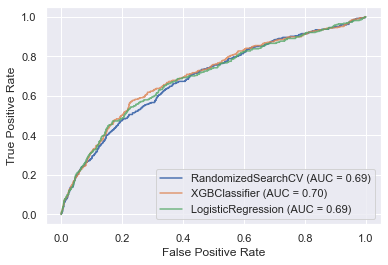

In [452]:
rf_disp = plot_roc_curve(random_search, X_test, y_test)
ax = plt.gca()
#stk_disp = plot_roc_curve(clf, X_test, y_test, ax=ax, alpha=0.8)
xgb_disp = plot_roc_curve(xgb_best1, X_test, y_test, ax=ax, alpha=0.8)
lr_disp = plot_roc_curve(logreg, X_test, y_test, ax=ax, alpha=0.8)
plt.show()

In [ ]:
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=5, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.02, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=600, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, silent=True, subsample=1.0,
              tree_method=None, validate_parameters=False, verbosity=None)

In [370]:
logreg = LogisticRegression(max_iter= 10000,tol = 1e-5,C=2)

In [371]:
%%time
logreg.fit(df_train[features],df_train.target)

Wall time: 1.2 s


LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=1e-05, verbose=0,
                   warm_start=False)

In [344]:
all_accuracies_data = cross_val_score(estimator=logreg, X=df_train[features], y=df_train.target, cv=5,scoring = 'roc_auc')
all_accuracies_data
print("Full Accuracy: %0.2f(+/- %0.2f)" % (all_accuracies_data.mean(), all_accuracies_data.std()*2))


array([0.68462019, 0.64692032, 0.67933648, 0.66991903, 0.67747652])

Full Accuracy: 0.67(+/- 0.03)


In [345]:
roc_auc_score(df_train.target, logreg.predict_proba(df_train[features])[:,1])

0.6806068848432775

In [346]:
pred_bin = logreg.predict(df_train[features])
precision_score(df_train.target,pred_bin)
recall_score(df_train.target,pred_bin)
confusion_matrix(df_train.target,pred_bin)
accuracy_score(df_train.target,pred_bin)
f1_score(df_train.target ,pred_bin)#df_train[features]

0.48717948717948717

0.007835051546391752

array([[15914,    20],
       [ 2406,    19]], dtype=int64)

0.8678577264556893

0.01542207792207792

In [348]:
df_sub = df_test[['enrollee_id']]
df_sub['target'] = logreg.predict_proba(df_test[features])[:,1]
df_sub['target'] = logreg.predict(df_test[features])
df_sub.to_csv(f'{path}/my_submission_v2.csv',index = False)

In [349]:
xgb

XGBClassifier(base_score=0.5, booster=None, colsample=0.7, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=69, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.9, tree_method=None,
              validate_parameters=False, verbosity=None)

In [353]:
train.target.value_counts()
15934/2425

0    15934
1     2425
Name: target, dtype: int64

6.570721649484536

In [302]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state = 69, colsample = 0.5, learning_rate = 0.05, subsample = 0.6,n_estimators =500,\
           scale_pos_weight  = 6.57,)

In [305]:
features = df_train.drop(['enrollee_id','city','experience','target'],axis =1).columns

In [306]:
%%time
xgb.fit(df_train[features],df_train.target)

Wall time: 10.3 s


XGBClassifier(base_score=0.5, booster=None, colsample=0.7, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=69, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.9, tree_method=None,
              validate_parameters=False, verbosity=None)

In [355]:

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = 10,shuffle = True, random_state=69)

In [356]:
all_accuracies_data = cross_val_score(estimator=xgb, X=df_train[features], y=df_train.target, cv=skf,\
                                      scoring = 'roc_auc')
all_accuracies_data
print("Full Accuracy: %0.2f(+/- %0.2f)" % (all_accuracies_data.mean(), all_accuracies_data.std()*2))


array([0.66553035, 0.61182689, 0.62616786, 0.63759112, 0.63971103,
       0.64570175, 0.67005211, 0.62965805, 0.61038003, 0.66262004])

Full Accuracy: 0.64(+/- 0.04)


In [357]:
all_accuracies_data

array([0.66553035, 0.61182689, 0.62616786, 0.63759112, 0.63971103,
       0.64570175, 0.67005211, 0.62965805, 0.61038003, 0.66262004])

In [360]:
roc_auc_score(df_train.target, xgb.predict_proba(df_train[features])[:,1])

0.9192726051664145

In [361]:
pred_bin = xgb.predict(df_train[features])
precision_score(df_train.target,pred_bin)
recall_score(df_train.target,pred_bin)
confusion_matrix(df_train.target,pred_bin)
accuracy_score(df_train.target,pred_bin)
f1_score(df_train.target ,pred_bin)#df_train[features]

0.9468599033816425

0.16164948453608247

array([[15912,    22],
       [ 2033,   392]], dtype=int64)

0.8880657987907838

0.2761535752025361

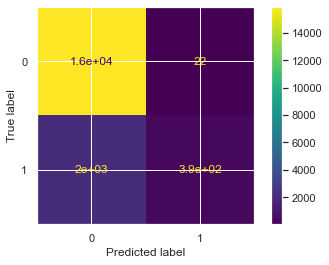

In [364]:
plot_confusion_matrix(estimator=xgb, X=df_train[features],y_true = df_train.target)

In [318]:
# 1- getting feature importance of variables with name for XGB model
def xgb_feature_imp(model):
    """
    Gives the feature importance along with variable names for an XGB Model.
    """
    return(pd.DataFrame({'features' : model.get_booster().feature_names, 'importance' : model.feature_importances_}).\
           sort_values('importance',ascending = False))


In [320]:
feat_imp = xgb_feature_imp(model = xgb)
feat_imp


,features,importance
10,company_size=missing,0.058355
2,city_event_rate,0.035126
37,last_new_job=never,0.031371
41,major_discipline=missing,0.030019
17,education_level=High School,0.025902
26,experience_band=low_exp,0.024776
24,enrolled_university=no_enrollment,0.024698
42,relevent_experience=Has relevent experience,0.024622
15,company_type=missing,0.023967
16,education_level=Graduate,0.023893


In [332]:
df_sub = df_test[['enrollee_id']]
df_sub['target'] = xgb.predict_proba(df_test[features])[:,1]
df_sub['target'] = xgb.predict(df_test[features])

In [333]:
df_sub.head()

,enrollee_id,target
0,16548,1
1,12036,0
2,11061,1
3,5032,0
4,17599,0


In [334]:
df_sub.to_csv(f'{path}/my_submission_v1.csv',index = False)

In [ ]:
train.company_type.unique()
pd.crosstab(train.company_size, train.company_type,dropna=False)

In [ ]:
#enrolled_university  --  Type of University course enrolled if any
var = 'company_size'
train[var].value_counts(dropna=False)

In [ ]:
train[var].value_counts()

In [ ]:
cdi_bands,bins = pd.qcut(train.city_development_index, q = 6,retbins= True,duplicates = 'drop')
train['cdi_bands'] = cdi_bands
#train.groupby(cdi_bands).city.count()
train.groupby(cdi_bands).target.sum()/train.groupby(cdi_bands).target.count()
train.drop('cdi_bands', axis = 1,inplace=True)

In [ ]:
train.head()

In [ ]:
train.groupby('company_size').target.sum()/train.groupby('company_size').target.count()

In [ ]:
train.company_size

In [ ]:
sns.countplot(x = 'gender', hue = 'target', data = train,palette="Set1");

In [ ]:
def crosstab_2var(df,var1,var2):
    return(pd.crosstab([df[var1], df["target"]], df[var2], margins = True).style.background_gradient(cmap = "Accent"))

In [ ]:
crosstab_2var(train,'gender','company_size')

In [ ]:
train.columns

In [ ]:
sns.scatterplot(x = train.city_development_index, y = train.training_hours)

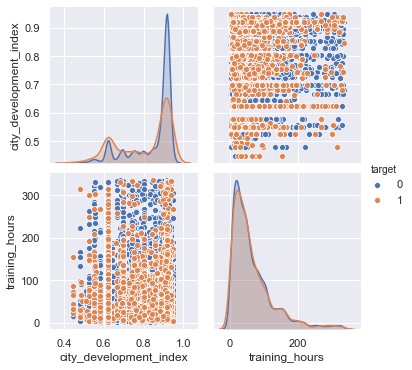

In [31]:
sns.pairplot(train.select_dtypes('number'), hue = 'target',)
